# TP 3: Uncertainty Applications

This last lab session will focus on applications based on uncertainty estimation. We will first use MC Dropout variational inference to qualitatively evaluate the most uncertain images for classification . 
Then, we'll apply the uncertainty for an important application: failure prediction.

**Goal**: Take hand on applying uncertainty estimation for classification and use it for failure prediction


**Student:** Lucas Versini

**Remark:** For the questions specified on the [website](https://thome.isir.upmc.fr/classes/MVA/index.html), the answers can be found in the PDF report. For other questions which require some interpretation/remarks, the answers can be found in this notebook.

## **Preliminary: download MNIST dataset**

**First, we will download the MNIST dataset** (train/test images and labels): [https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl](https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl)

**Then, the dataset will be loaded into memory to speed up computations:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.pyplot import imread
%matplotlib inline
import _pickle as pickle 
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

!wget https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl
outfile = 'mnist-data.pcl'
[X_train, y_train,X_test, y_test] = pickle.load( open( outfile, "rb" ) )
 
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

--2024-12-14 14:06:41--  https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324509627 (309M) [application/octet-stream]
Saving to: ‘mnist-data.pcl.9’

mnist-data.pcl.9    100%[===================>] 309.48M  63.1MB/s    in 4.9s    

2024-12-14 14:06:48 (63.5 MB/s) - ‘mnist-data.pcl.9’ saved [324509627/324509627]



## **Part I : MC Dropout for classification on MNIST**

**We will design a 'LeNet-like' Convolutional neural network (ConvNet) with the following architecture:**

- A conv layer with 16 5x5 filters, followed by a max pooling a size (2,2)
- A conv layer with 32 5x5 filters, followed by a max pooling a size (2,2). From this stage, flatten the tensor
- A dropout layer with p=0.5
- A fully connected layer with 100 hidden units, and ReLU activation
- A dropout layer with p=0.25
- A fully connected layer with 10 output classes 

### **I.1: Training a ConvNet with dropout on MNIST**

In [2]:
#TO DO: Code a LeNet-style neural network. 
class LeNet(nn.Module):
    def __init__(self, n_classes = 10):
        super().__init__()       
        # To do
        self.training = True
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 10)

        
    def forward(self, x):
        # To do
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 32 * 4 * 4)
        x = F.dropout(x, 0.5, training = self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.25, training = self.training)
        x = self.fc2(x)
        return x

In [3]:
if(use_cuda ==True):
    net = LeNet().cuda() 
else:
    net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


**Now, fill the code below to train the network for 20 epochs**

In [4]:
tbatch =100
nb_epochs=20
nbbatchs = int(X_train.shape[0]/100)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

net.train()

for epoch in range(nb_epochs):  # loop over the dataset multiple times
    epoch_loss = 0
    for i in range(nbbatchs):
        X_batch = X_train[i*100:(i+1)*100,:,:]
        y_batch = y_train[i*100:(i+1)*100]
        # Compute forward / backward
        optimizer.zero_grad()
        outputs = net(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch}, loss: {epoch_loss/nbbatchs:.5f}")
    
# Save your model in case the session crashes
torch.save(net.state_dict(), 'lenet_final.cpkt')

Epoch 0, loss: 0.29983
Epoch 1, loss: 0.10907
Epoch 2, loss: 0.08374
Epoch 3, loss: 0.07145
Epoch 4, loss: 0.06371
Epoch 5, loss: 0.06119
Epoch 6, loss: 0.05460
Epoch 7, loss: 0.04989
Epoch 8, loss: 0.04692
Epoch 9, loss: 0.04768
Epoch 10, loss: 0.04521
Epoch 11, loss: 0.04184
Epoch 12, loss: 0.04246
Epoch 13, loss: 0.04188
Epoch 14, loss: 0.03751
Epoch 15, loss: 0.03898
Epoch 16, loss: 0.03885
Epoch 17, loss: 0.03592
Epoch 18, loss: 0.03608
Epoch 19, loss: 0.03296


### **I.2: MC sampling on test set**
Once your ConvNet model with dropout is trained, apply MC sampling in the test set to approximate the predictive distribution for each sample 

In [5]:
#net.load_state_dict(torch.load('./simple/TP3/lenet_final.cpkt'))

In [6]:
# complete the following function: parse the dataset in a batch manner, run the network with dropout 
# sampling activated to get multiple predictions for each image
def MC_sampling(X,y , net, tbatch=100, samples=200):
    net.eval()
    net.training=True
    outputs = torch.zeros(samples, X.shape[0], 10)
    # COMPLETE WITH YOUR CODE

    with torch.no_grad():
        for i in tqdm(range(samples), desc='MC sampling'):
            for j in range(0, X.shape[0], tbatch):
                X_batch = X[j:j + tbatch]
                outputs[i, j:j + tbatch] = net(X_batch)
    
    return outputs

In [7]:
MC_samples = MC_sampling(X_test,y_test,net)

MC sampling:   0%|          | 0/200 [00:00<?, ?it/s]

**We will now compute a classification uncertainty metric based on predictive distribution on test images.**

Let us consisder an image $\mathbf{x}$, for which we have a set of $N_S$ samples, each sample corresponding to a vector of size $N_C$ ($N_C$ being the number of classes). We compute an histogram of predictions over the $N_S$ samples: the histogram dispersion provides an indicator of the predictive uncertainty.
Specifically, we use the following "variation-ratio" metric: 

$$ variation-ratio[\mathbf{x}] = 1 - \frac{f_x^{c^*}}{T}
$$

where $f_x^{c^*}$ is the number of occurences in histogram corresponding to the majority class, (*i.e.* the mode) ${c^*}$.

We can compute the predictions histograms as follows: 

In [8]:
nS = MC_samples.shape[0]
MC_samples_SM = F.softmax(MC_samples, dim=2) # Apply soft-max
nbtest = X_test.shape[0]
am = np.argmax(MC_samples, axis=2) # Compute predicted class for each MC sampling and each example
hists = [np.histogram(am[:,i], range=(0,10)) for i in range(nbtest)]

Then the model predictions for each example are computing as the majority class among MC samples:

In [9]:
pred_vr = [0 for i in range(10000)]
for i in range(10000):
    pred_vr[i] = np.argmax(hists[i][0])
pred_vr2 = torch.tensor(np.array(pred_vr)) 

**From prediction histograms, compute the "variation-ratio" uncertainty metric:**

In [10]:
fx = np.array([hists[idx][0][pred] / nS for idx, pred in enumerate(pred_vr)]) # COMPLETE with your code
var_ratio = 1.0-fx

We can then sort test examples by increasing confidence $f_x$

In [11]:
uncertain_samples = np.argsort(fx) # COMPLETE with your code

**The following function can be used to draw 25 images ranked from index m regarding confidence:**

In [12]:
def showImages(m , var_ratio , uncertain_samples, X_test):
    # Visualize some images
    fig, axes = plt.subplots(nrows=5, ncols=5, dpi=150)
    
    for i in range(m,m+25):
        ist = i-m
        title = "VR="+"{0:.3f}".format(var_ratio[uncertain_samples[i]])
        axes[ist // 5][ist % 5].set_title(title, fontsize=6)
        axes[ist // 5][ist % 5].imshow(X_test[uncertain_samples[i],0,:,:].cpu(), cmap='gray')
        axes[ist // 5][ist % 5].set_xticks([])
        axes[ist // 5][ist % 5].set_yticks([])
    fig.set_size_inches(5, 5)
    fig.tight_layout()

**Explore image with low and high confidence. Look at images and comment the confidence metric.**

**Answer:** See the report.

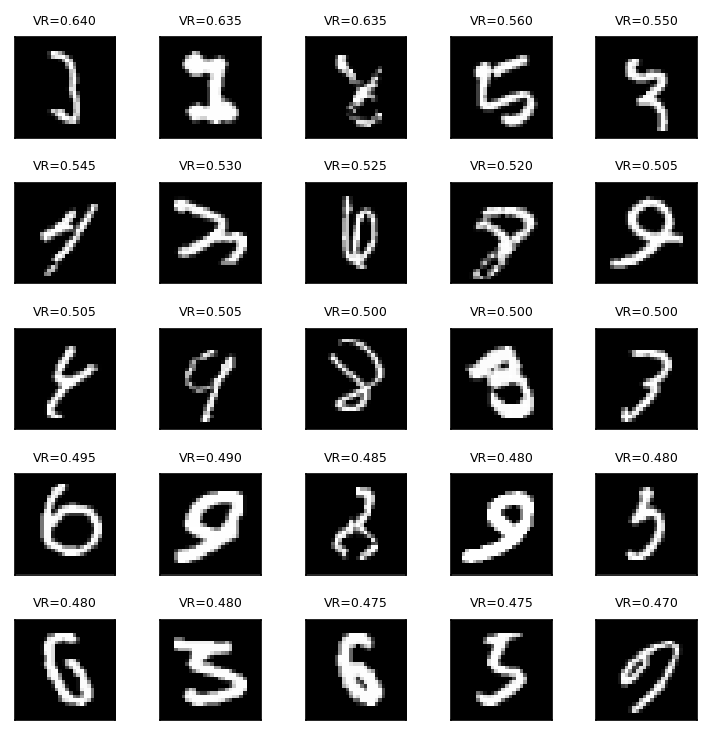

In [13]:
showImages(0,var_ratio , uncertain_samples, X_test)

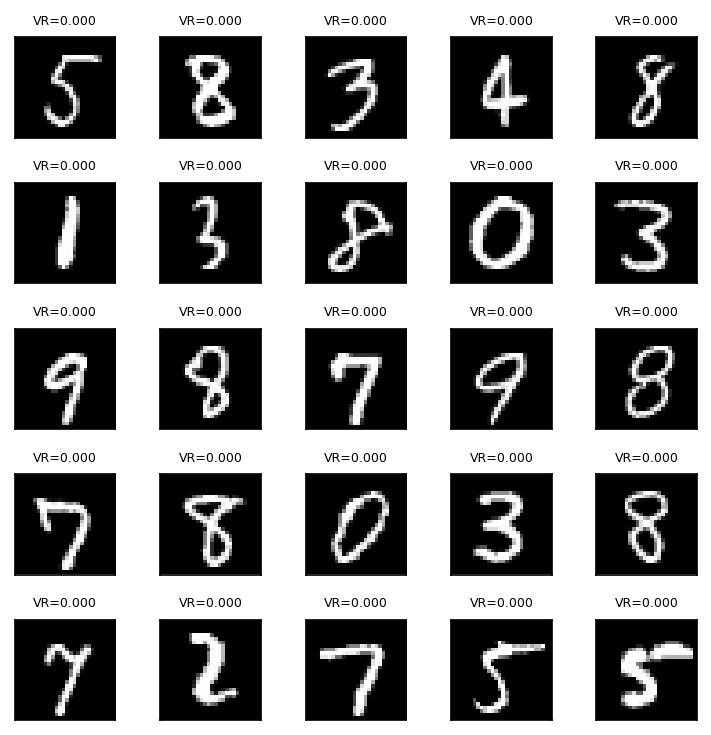

In [14]:
showImages(8000,var_ratio , uncertain_samples, X_test)

**Finally, the following showUncertainty function can be used to visualize the predictions for a given input image:**
- The mean prediction over MC samples
- The histogram predictions
- The histogram of predictions for the 3 leading classes


In [15]:
def showUncertainty(MC_sample, hist, img, title):
    size=10
    
    sSM = F.softmax(MC_sample,dim=1)
    pred_mean = sSM.mean(axis=0)
       
    fig = plt.figure(dpi=150)  
    fig.suptitle(title, fontsize="x-large")
    fig.set_figheight(4)
    fig.set_figwidth(4*5)
    ax = plt.subplot(161)
    plt.imshow(img, cmap='gray')
    plt.axis('off')        
   
    ax = plt.subplot(162)
    ax.bar(range(10),pred_mean)
    ax.set_title("Mean Pred")
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax.set_xticks(range(10))
    
    ax = plt.subplot(163)
    ax.bar(range(10),hist)
    ax.set_title("Samples Pred")
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    
    asorted = np.argsort(pred_mean, axis=0)
     
   
    h1 = np.histogram(sSM[:,asorted[9]], range=(0.0,1.0))
    h2 = np.histogram(sSM[:,asorted[8]], range=(0.0,1.0))
    h3 = np.histogram(sSM[:,asorted[7]], range=(0.0,1.0))

    ax =plt.subplot(164)
    ax.bar(range(10),h1[0])
    ax.set_title("Class="+str(asorted[9].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax = plt.subplot(165)
    ax.bar(range(10),h2[0])
    ax.set_title("Class="+str(asorted[8].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax = plt.subplot(166)
    ax.bar(range(10),h3[0])
    ax.set_title("Class="+str(asorted[7].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    plt.show()


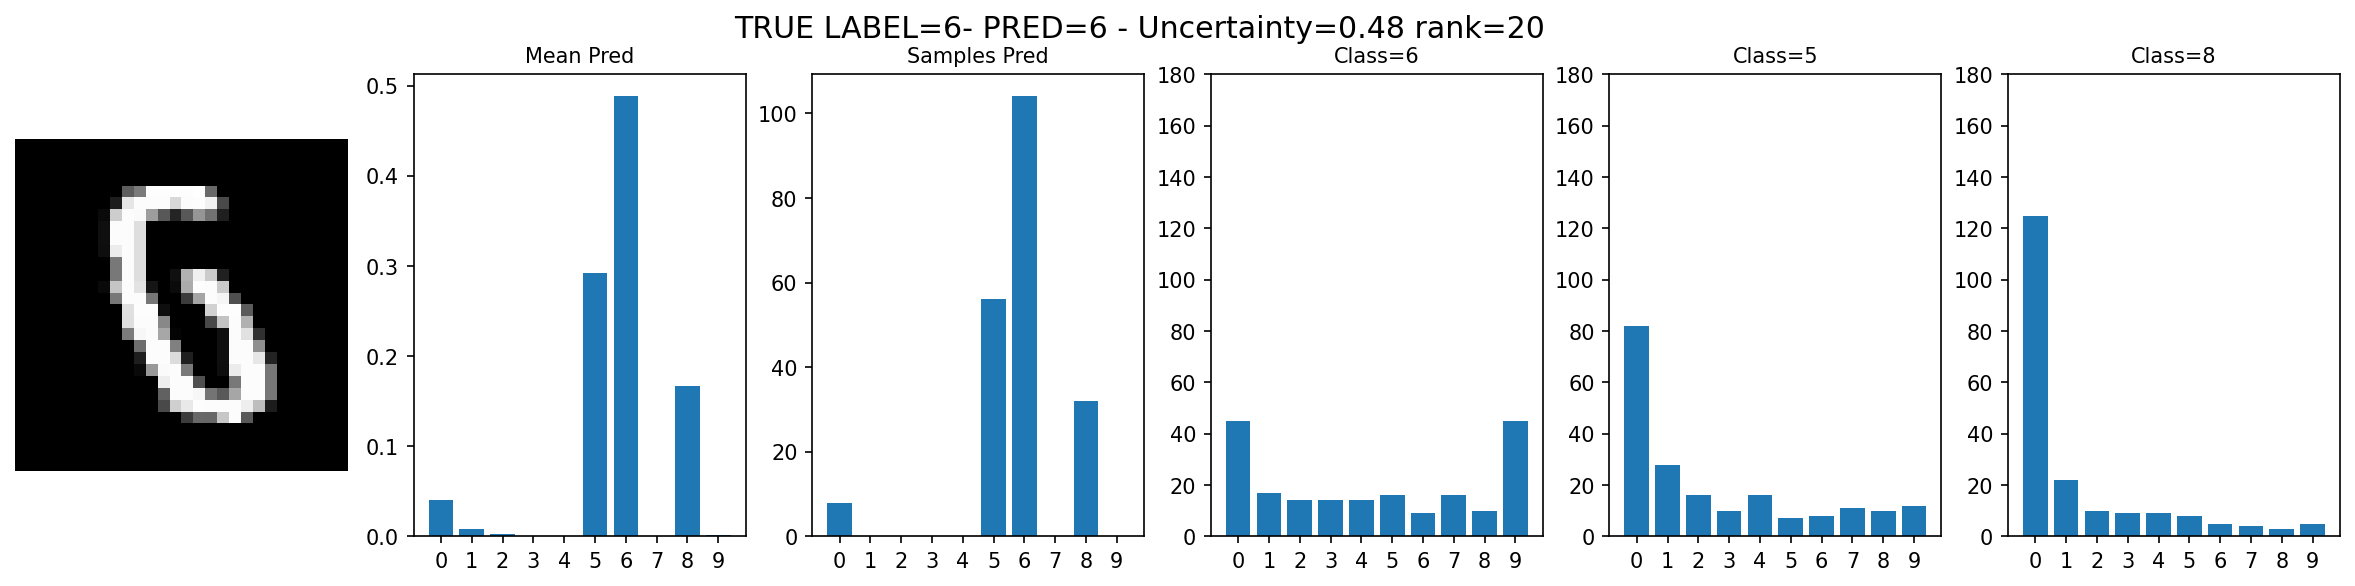

In [16]:
min =10
max=100

cpt=np.random.randint(min,max)
index = uncertain_samples[cpt]
    
title = "TRUE LABEL="+str(y_test[index].cpu().numpy())+"- PRED="+str(pred_vr2[index].cpu().numpy())+ " - Uncertainty="+str("{:0.2f}".format(var_ratio[index]))+" rank="+str(cpt)
showUncertainty(MC_samples[:,index,:], hists[index][0], X_test[index,0,:,:].reshape([28,28]).cpu(), title)


## **Part II : Failure Prediction**

**The objective is to provide confidence measures for model’s predictions that are reliable and whoseranking among samples enables to distinguish correct from incorrect predictions. Equipped with sucha confidence measure, a system could decide to stick to the prediction or, on the contrary, to handover to a human or a back-up system with, *e.g.* other sensors, or simply to trigger an alarm.**

<img src="https://thome.isir.upmc.fr/classes/MVA/failure.png" title="Failure prediction">

**We will introduce ConfidNet, a specific method design to address failure prediction and we will compare it to MCDropout with entropy and Maximum Class Probability (MCP).**

### **II.1 ConfidNet**

By taking the largest softmax probability as confidence estimate, MCP leads to high confidence values both for correct and erroneous predictions alike. On the other hand, when the model misclassifies an example, the probability associated to the true class $y$ is lower than the maximum one and likely to be low.

Based on this observation, we can consider instead the **True Class Probability** as a suitable uncertainty criterion.
For any admissible input $\pmb{x}\in \mathcal{X}$, we assume the *true* class $y(\pmb{x})$ is known, which we denote $y$ for simplicity. The TCP of a model $F$ is defined as  
\begin{equation}
    \text{TCP}_F(\pmb{x},y) = P(Y=y \vert \pmb{x}, \hat{\pmb{w}})
\end{equation}

**Theoretical guarantees.** Given a properly labelled example $(\pmb{x},y)$, then:
- $\text{TCP}_F(\pmb{x},y)> 1/2$ $\Rightarrow$ $f(\pmb{x}) = y$, *i.e.* the example is correctly classified by the model;%the example has been correctly classified,
- $\text{TCP}_F(\pmb{x},y) < 1/K$ $\Rightarrow$ $f(\pmb{x}) \neq y$, *i.e.* the example is wrongly classified by the model.

However, the true classes $y$ are obviously not available when estimating confidence on test inputs. Alternatively, we can **learn TCP criterion from data** with an auxiliary model called **ConfidNet**.

ConfidNet is designed as a small multilayer perceptron composed of a succession of dense layers with a final sigmoid activation that outputs $C(\pmb{x};\pmb{\theta})\in[0,1]$. We use a mean-square-error (MSE) loss to train this model:
\begin{equation} 
\mathcal{L}_{\text{conf}}(\pmb{\theta};\mathcal{D}) = \frac{1}{N} \sum_{n=1}^N \big(C(\pmb{x}_n;\pmb{\theta}) - \text{TCP}_F(\pmb{x}_n,y_n)\big)^2.
\end{equation}

<img src="https://thome.isir.upmc.fr/classes/MVA/confidnet.jpg" title="ConfidNet">

In [17]:
class LeNetConfidNet(nn.Module):
    ''' A LeNet-syle model equipped with ConfidNet auxiliary branch '''
    def __init__(self, n_classes=10):
        super(LeNetConfidNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*32, 100)  # 6*6 from image dimension
        self.fc2 = nn.Linear(100, 10)
        
        # ConfidNet Layers
        self.uncertainty1 = nn.Linear(100, 400)
        self.uncertainty2 = nn.Linear(400, 400)
        self.uncertainty3 = nn.Linear(400, 400)
        self.uncertainty4 = nn.Linear(400, 400)
        self.uncertainty5 = nn.Linear(400, 1)

    def forward(self, x):
       # Max pooling over a (2, 2) window
        out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = out.view(-1, self.num_flat_features(out))
        out = F.dropout(out, 0.5, training=self.training)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.25, training=self.training)

        # Uncertainty prediction
        uncertainty = F.relu(self.uncertainty1(out))
        uncertainty = F.relu(self.uncertainty2(uncertainty))
        uncertainty = F.relu(self.uncertainty3(uncertainty))
        uncertainty = F.relu(self.uncertainty4(uncertainty))
        uncertainty = self.uncertainty5(uncertainty)
  
        pred = self.fc2(out)
        return pred, uncertainty
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [18]:
class SelfConfidMSELoss(nn.modules.loss._Loss):
    ''' MSE Loss for confidence learning '''
    def __init__(self, num_classes,device):
        self.nb_classes = num_classes
        self.device = device
        super().__init__()

    def forward(self, input, target):
        probs = F.softmax(input[0], dim=1)
        confidence = torch.sigmoid(input[1]).squeeze()
        labels_hot = torch.eye(10).to(device)[target.flatten()].to(device)
        loss = (confidence - (probs * labels_hot).sum(dim=1)) ** 2
        return torch.mean(loss)

**We train only the ConfidNet layers for 50 epochs. During confidence learning, original classification layers are fixed to keep predictions unchanged.**

In [19]:
lenet_confidnet = LeNetConfidNet(n_classes=10).to(device)
lenet_confidnet.load_state_dict(torch.load('lenet_final.cpkt'), strict=False)
lenet_confidnet.train()
optimizer = torch.optim.Adam(lenet_confidnet.parameters(), lr=1e-4)
criterion = SelfConfidMSELoss(10,device)

tbatch =100
nb_epochs=50
nbbatchs = int(X_train.shape[0]/100)

# Freezing every layer except uncertainty for confidence training
for param in lenet_confidnet.named_parameters():
    if "uncertainty" in param[0]:
        continue
    param[1].requires_grad = False

best_aupr = 0.0

for e in range(nb_epochs):
    lenet_confidnet.train()

    total_loss, correct = 0.0, 0.0
    errors, uncertainty = [], []

    for i in range(nbbatchs):
        X_batch = X_train[i*100:(i+1)*100,:,:]
        y_batch = y_train[i*100:(i+1)*100]
        
        optimizer.zero_grad()
        
        output = lenet_confidnet(X_batch)
        probs = F.softmax(output[0], dim=1)
        pred = probs.max(dim=1)[1]
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss
        correct += (pred == y_batch).sum()
        errors.extend((pred != y_batch.view_as(pred)).detach().to("cpu").numpy())
        uncertainty.extend(output[1].squeeze().detach().to("cpu").numpy())

    errors_test, uncertainty_test = [], []
    lenet_confidnet.eval()
    nbbatchstest = int(X_test.shape[0]/tbatch)
    for i in range(nbbatchstest):
        X_batch = X_test[i*100:(i+1)*100,:,:]
        y_batch = y_test[i*100:(i+1)*100]
        with torch.no_grad():
          output = lenet_confidnet(X_batch)
        pred = output[0].max(dim=1)[1]
        errors_test.extend((pred != y_batch.view_as(pred)).detach().to("cpu").numpy())
        uncertainty_test.extend(output[1].squeeze().detach().to("cpu").numpy())

    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()
    uncertainty = np.reshape(uncertainty, newshape=(len(uncertainty), -1)).flatten()
    aupr = average_precision_score(errors, -uncertainty)
    errors_test = np.reshape(errors_test, newshape=(len(errors_test), -1)).flatten()
    uncertainty_test = np.reshape(uncertainty_test, newshape=(len(uncertainty_test), -1)).flatten()
    print(f"[Epoch {e + 1}] loss: {total_loss/ X_train.shape[0]:.2E}"+
          f"\t accuracy_train: {correct / X_train.shape[0]:.2%}"+
          f"\t aupr_train: {aupr:.2%}"+
          f"\t aupr_test: {average_precision_score(errors_test, -uncertainty_test):.2%}")
    if aupr>best_aupr:
      best_aupr = aupr
      torch.save(lenet_confidnet.state_dict(), 'lenet_confidnet_best.cpkt')

lenet_confidnet.load_state_dict(torch.load('lenet_confidnet_best.cpkt'))

/tmp/ipykernel_2069744/4030718345.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_confidnet.load_state_dict(torch.load('lenet_final.cpkt'), strict=False)


[Epoch 1] loss: 1.12E-04	 accuracy_train: 98.98%	 aupr_train: 3.14%	 aupr_test: 14.76%
[Epoch 2] loss: 7.69E-05	 accuracy_train: 98.95%	 aupr_train: 7.22%	 aupr_test: 19.44%
[Epoch 3] loss: 7.63E-05	 accuracy_train: 98.93%	 aupr_train: 8.66%	 aupr_test: 21.45%
[Epoch 4] loss: 7.26E-05	 accuracy_train: 98.95%	 aupr_train: 10.66%	 aupr_test: 26.07%
[Epoch 5] loss: 6.77E-05	 accuracy_train: 98.95%	 aupr_train: 16.13%	 aupr_test: 25.62%
[Epoch 6] loss: 6.52E-05	 accuracy_train: 98.96%	 aupr_train: 16.42%	 aupr_test: 29.48%
[Epoch 7] loss: 6.82E-05	 accuracy_train: 98.87%	 aupr_train: 18.49%	 aupr_test: 33.06%
[Epoch 8] loss: 6.18E-05	 accuracy_train: 98.96%	 aupr_train: 20.85%	 aupr_test: 33.62%
[Epoch 9] loss: 6.51E-05	 accuracy_train: 98.87%	 aupr_train: 25.09%	 aupr_test: 33.36%
[Epoch 10] loss: 5.96E-05	 accuracy_train: 98.90%	 aupr_train: 29.04%	 aupr_test: 34.70%
[Epoch 11] loss: 5.94E-05	 accuracy_train: 98.88%	 aupr_train: 29.31%	 aupr_test: 36.45%
[Epoch 12] loss: 5.51E-05	 accura

/tmp/ipykernel_2069744/4030718345.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_confidnet.load_state_dict(torch.load('lenet_confidnet_best.cpkt'))


<All keys matched successfully>

In [20]:
# If you already train your model, you can load it instead using :
#lenet_confidnet.load_state_dict(torch.load('lenet_confidnet_best.cpkt'))

### **II.2 Evaluate failure prediction performances**

**We compare the capacity of ConfidNet to detect failures with previous baselines (MCP and MCDropout with variation-ratio).**

To measure performances, we use the *Area under the Precision-Recall* curve (AUPR). The precision-recall (PR) curve is the graph of the precision $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FP})$ as a function of the recall $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FN})$ where $\mathrm{TP}$, $\mathrm{TN}$, $\mathrm{FP}$ and $\mathrm{FN}$ are the numbers of true positives, true negatives, false positives and false negatives respectively. In our experiments, classification errors are used as the positive detection class.

**We can use the following function for test set prediction:**

In [21]:
#@title **[CODING TASK]** Implement variational-ratio, entropy and mutual information

def predict_test_set(model, X_test,y_test, mode='mcp', s=100, temp=5, epsilon=0.0006, verbose=True):
    """Predict on a test set given a model 
    # and a chosen method to compute uncertainty estimate
    # (mcp, MC-dropout with var-ratios/entropy/mutual information 
    # ConfidNet and ODIN)

    Args:
      model: (nn.Module) a trained model
      X_test,y_test: Data & labels
      mode: (str) chosen uncertainty estimate method (mcp, var-ratios, entropy, mi, odin)
      s: (int) number of samples in MCDropout
      temp: (int, optional) value of T for temperature scaling in ODIN
      epsilon: (float, optional) value of epsilon for inverse adversarial perturbation in ODIN
      verbose: (bool, optional) printing progress bar when predicting   
      
    Returns:
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
    """
    tbatch =100
    nbbatchs = int(X_test.shape[0]/100)

    preds, uncertainties, labels, errors  = [], [], [], []
    mc_samples, hists = [], []
    model.eval()
    
    #loop = tqdm(test_loader, disable=not verbose)
    for i in range(nbbatchs):
        images = X_test[i*100:(i+1)*100,:,:]
        targets = y_test[i*100:(i+1)*100]

        if mode in ['mcp','odin']:
            model.training = False           
            if mode=='odin':
                # Coding task in Section 3: implement ODIN
                images = odin_preprocessing(model,images,epsilon).to(device)
            with torch.no_grad():
                output = model(images)
            if isinstance(output,tuple):
                output = output[0]
            if mode =='odin':
                output = output / temp
            confidence, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            confidence = confidence.detach().to('cpu').numpy()
            
        elif mode in ['var-ratios', 'entropy', 'mut_inf']:
            model.training = True
            outputs = torch.zeros(images.shape[0], s, 10)
            for i in range(s):
                with torch.no_grad():
                    output = model(images)
                    if isinstance(output,tuple):
                        output = output[0]
                    outputs[:,i] = output
            mc_probs = F.softmax(outputs, dim=2)
            predicted_class = mc_probs.max(dim=2)[1]
            pred = mc_probs.mean(1).max(dim=1, keepdim=True)[1]
            mc_samples.extend(mc_probs)
            hist = np.array([np.histogram(predicted_class[i,:], range=(0,10))[0]  
                              for i in range(predicted_class.shape[0])])
            hists.extend(hist)
            
            # ============ YOUR CODE HERE ============
            if mode=='var-ratios':
                # You may want to use the hist variable here
                confidence = 1. - hist.max(axis=1)/s
            elif mode=='entropy':
                confidence = -(mc_probs.mean(1)*torch.log(mc_probs.mean(1)+1e-9)).sum(dim=1)
            elif mode=='mut_inf':
                confidence = -(mc_probs.mean(1)*torch.log(mc_probs.mean(1)+1e-9)).sum(dim=1) \
                                    + (mc_probs*torch.log(mc_probs+1e-9)).sum(dim=2).mean(dim=1)
            # ======================================= 
        
        elif mode=='confidnet':
          with torch.no_grad():
            output, confidence = model(images)
          _, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
          confidence = confidence.detach().to('cpu').numpy()

        preds.extend(pred.cpu())
        labels.extend(targets.cpu())
        uncertainties.extend(confidence)
        errors.extend((pred.to(device)!=targets.view_as(pred)).detach().to("cpu").numpy())

    preds = np.reshape(preds, newshape=(len(preds), -1)).flatten()
    labels = np.reshape(labels, newshape=(len(labels), -1)).flatten()
    uncertainties = np.reshape(uncertainties, newshape=(len(uncertainties), -1)).flatten()
    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()

    if mode in ['var-ratios', 'entropy', 'mi']:
        hists = np.reshape(hists, newshape=(len(hists), -1))

    print(f'Test set accuracy = {(preds == labels).sum()/len(preds):.2%}')
    
    return preds, labels, uncertainties, errors, hists, mc_samples

In [22]:
#@title **[CODING TASK]** Compute precision and recall vectors along with AUPR score for ConfidNet

# ============ YOUR CODE HERE ============
# Use predict_test_set function to obtain confidence estimates
# with previous model, choosing 'confidnet' mode. 
# Then then calculate the precision, recall and aupr 
# with sklearn functions.
# /!\ In failure prediction, errors are consider 
# as the positive class

preds, labels, uncertainties, errors, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode = "confidnet")
prediction = torch.sigmoid(-torch.tensor(uncertainties))

aupr_confidnet = average_precision_score(errors, prediction)
precision_confidnet, recall_confidnet, thresholds = precision_recall_curve(errors, prediction, pos_label = 1)

Test set accuracy = 99.29%


In [23]:
#@title **[CODING TASK]** Same with MCP

# ============ YOUR CODE HERE ============
# Mode = 'mcp'

preds, labels, uncertainties, errors, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode = "mcp")
prediction = torch.sigmoid(-torch.tensor(uncertainties))

aupr_mcp = average_precision_score(errors, prediction)
precision_mcp, recall_mcp, thresholds = precision_recall_curve(errors, prediction, pos_label = 1)

Test set accuracy = 99.29%


In [24]:
#@title **[CODING TASK]** Same with MCDropout 

# ============ YOUR CODE HERE ============
# Mode = 'entropy'

preds, labels, uncertainties, errors, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode = "entropy")
prediction = torch.sigmoid(torch.tensor(uncertainties))

aupr_mc_dropout = average_precision_score(errors, prediction)
precision_mc_dropout, recall_mc_dropout, thresholds = precision_recall_curve(errors, prediction, pos_label = 1)

Test set accuracy = 99.29%


**Let**'s look at the comparative results for failure prediction

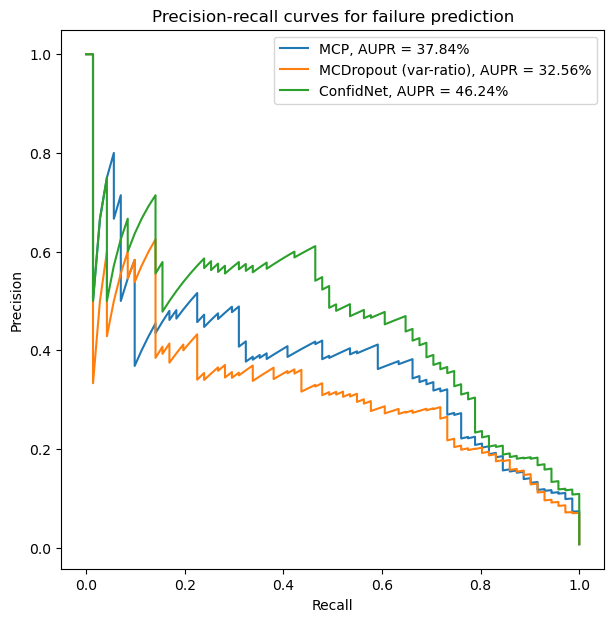

In [25]:
plt.figure(figsize=(7,7))
plt.plot(recall_mcp, precision_mcp, label = f'MCP, AUPR = {aupr_mcp:.2%}')
plt.plot(recall_mc_dropout, precision_mc_dropout, label = f'MCDropout (var-ratio), AUPR = {aupr_mc_dropout:.2%}')
plt.plot(recall_confidnet, precision_confidnet, label = f'ConfidNet, AUPR = {aupr_confidnet:.2%}')
plt.title('Precision-recall curves for failure prediction')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Part III: Out-of-distribution detection

Modern neural networks are known to generalize well when the training and testing data are sampled from the same distribution. However, when deploying neural networks in real-world applications, there is often very little control over the testing data distribution. It is important for classifiers to be aware of uncertainty when shown new kinds of inputs, i.e., out-of- distribution examples. Therefore, being able to accurately detect out-of-distribution examples can be practically important for visual recognition tasks.

<img src="https://thome.isir.upmc.fr/classes/MVA/ood.png" title="OOD detection">

In this section, we will use Kuzushiji-MNIST, a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images) containing 3832 Kanji (japanese) characters, as out-of-distribution sample to our model trained on MNIST. We will compare the methods for uncertainty estimates used previously and ODIN. 

--2024-12-14 14:14:40--  https://thome.isir.upmc.fr/classes/MVA/Kmnist-data-test.pcl
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46214172 (44M) [application/octet-stream]
Saving to: ‘Kmnist-data-test.pcl.5’

Kmnist-data-test.pc 100%[===================>]  44.07M  41.4MB/s    in 1.1s    

2024-12-14 14:14:42 (41.4 MB/s) - ‘Kmnist-data-test.pcl.5’ saved [46214172/46214172]



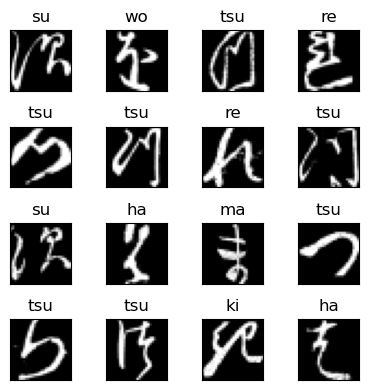

In [26]:
from torchvision import datasets, transforms

# Load KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
kmnist_test_dataset = datasets.KMNIST('data', train=False, download=True, transform=transform)

!wget https://thome.isir.upmc.fr/classes/MVA/Kmnist-data-test.pcl
outfile = 'Kmnist-data-test.pcl'
[X_testK, y_testK] = pickle.load( open( outfile, "rb" ) )

X_testK = X_testK.to(device)
y_testK = y_testK.to(device)

# Visualize some images
fig, axes = plt.subplots(nrows=4, ncols=4)
for i in range(16):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(X_testK.cpu()[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{kmnist_test_dataset.classes[y_testK[i]]}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

**We compute the precision, recall and AUPR metric for OOD detection with MCP and MCDropout with var-ratios**

In [27]:
# Compute predictions for MCP method on MNIST
_, _, uncertainty_mcp, errors_mcp, _, _ = predict_test_set(net, X_test,y_test, mode='mcp')

# Same on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(net, X_testK,y_testK, mode='mcp')

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_mcp, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_mcp), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_mcp, recall_ood_mcp, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_mcp = average_precision_score(in_distribution, -tot_uncertainty)

Test set accuracy = 99.29%
Test set accuracy = 9.27%


In [28]:
# Computing for MCDropout with var-ratios
_, _, uncertainty_mc_dropout, _, _, _ = predict_test_set(net, X_test,y_test, mode='var-ratios')
_, _, uncertainty_mc_dropout_kmnist, _, _, _ = predict_test_set(net, X_testK,y_testK, mode='var-ratios')
tot_uncertainty = np.concatenate((uncertainty_mc_dropout, uncertainty_mc_dropout_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_mc_dropout), np.ones_like(uncertainty_mc_dropout)))

precision_ood_mc_dropout, recall_ood_mc_dropout, _ = precision_recall_curve(in_distribution, tot_uncertainty)
aupr_ood_mc_dropout = average_precision_score(in_distribution, tot_uncertainty)

Test set accuracy = 99.32%
Test set accuracy = 8.95%


We will now implement the ODIN method.

ODIN [[Liang et al., ICLR 2018](https://openreview.net/pdf?id=H1VGkIxRZ)], is a threshold-based detector enhancing maximum softmax probabilities with two extensions:
- **temperature scaling**: 
	$ \textit{p}(y= c \vert \mathbf{x}, \mathbf{w}, T) = \frac{\exp(f_c( \mathbf{x}, \mathbf{w}) / T)}{\sum_{k=1}^K \exp(f_k( \mathbf{x}, \mathbf{w}) / T)} $
where $T \in \mathbb{R}^{+}$
- **inverse adversarial perturbation**: $ \tilde{\mathbf{x}} = \mathbf{x} - \epsilon \mathrm{sign} \big ( - \nabla_x \log (\textit{p}(y = \hat{y} \vert \mathbf{x}, \mathbf{w}, T) \big ) $

Both technics aimed to increase in-distribution MCP higher than out-distribution MCP. Here, we set the hyperparameters $T=5$ and $\epsilon=0.0014$.

In [32]:
#@title **[CODING TASK]** Implement ODIN preprocessing

def odin_preprocessing(model, input, epsilon):      
    # We perform the invese adversarial perturbation
    # You can find some help in the link below:
    # https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

    # ============ YOUR CODE HERE ============
    # 1. Set requires_grad attribute of tensor. Important for Attack
    input.requires_grad = True

    # 2. Forward pass the data through the model
    output = model(input)

    # 3. Calculate the loss w.r.t to class predictions
    loss = F.cross_entropy(output, torch.argmax(output, dim = 1))

    # 4. Zero all existing gradients
    model.zero_grad()

    # 5. Calculate gradients of model in backward pass
    loss.backward()

    # 6. Collect sign of datagrad
    sign_input_grad = input.grad.data.sign()

    # 7. Normalizing the gradient to the same space of image
    sign_input_grad = sign_input_grad / 0.3081

    # 8. Apply FGSM Attack
    perturbed_input = input - epsilon * sign_input_grad

    return perturbed_input

In [33]:
net.training = False

# Compute predictions for ODIN on MNIST
_, _, uncertainty_odin, errors_odin, _, _ = predict_test_set(net, X_test,y_test, mode='odin', temp=5, epsilon=0.0014)

# Compute predictions for ODIN on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(net, X_testK,y_testK, mode='odin', temp=5, epsilon=0.0014)

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_odin, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_odin), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_odin, recall_ood_odin, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_odin = average_precision_score(in_distribution, -tot_uncertainty)

Test set accuracy = 99.29%
Test set accuracy = 9.27%


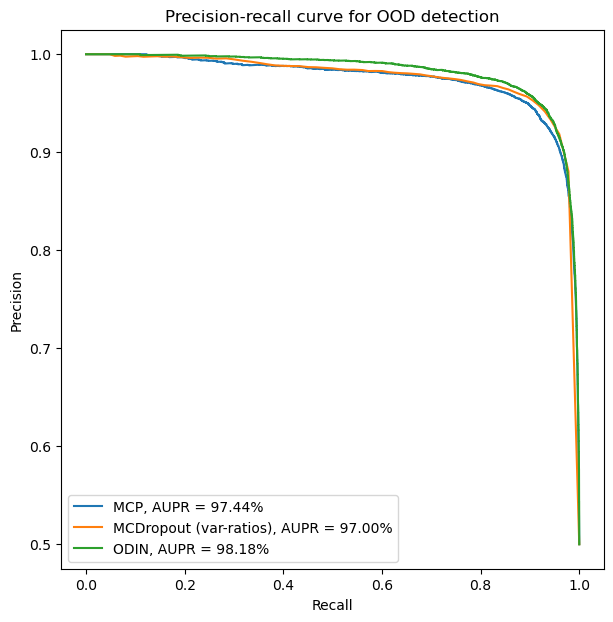

In [34]:
plt.figure(figsize=(7,7))
plt.title('Precision-recall curve for OOD detection')
plt.plot(recall_ood_mcp, precision_ood_mcp, label = f'MCP, AUPR = {aupr_ood_mcp:.2%}')
plt.plot(recall_ood_mc_dropout, precision_ood_mc_dropout, label = f'MCDropout (var-ratios), AUPR = {aupr_ood_mc_dropout:.2%}')
plt.plot(recall_ood_odin, precision_ood_odin, label = f'ODIN, AUPR = {aupr_ood_odin:.2%}')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**[Question 3.1]: Compare the precision-recall curves of each OOD method along with their AUPR values. Which method perform best and why?**

**Answer:** See the report.